Importing the Libraries
-----------

In [6]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightkurve as lk
from modules import *
from astropy.table import Table
import scipy.signal as signal
import scipy.optimize as optimize
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from tqdm import tqdm


plt.style.use('seaborn-v0_8-darkgrid')
plt.style.use('default')

#TIC, star = 'TIC 372519345', "OY Car"
# TIC, star = 'TIC 346897118', "AY Psc"
# TIC, star = 'TIC 61285257', "DO Leo"
#TIC,star = 'TIC 238609772', "GY Cnc"
# TIC, star = "TIC 304628774", "HBHA 4204−09"
#TIC, star = 'TIC 9560142', "EX Hya"
#TIC, star = 'TIC 3034524', "QZ Aur"
TIC, star = 'TIC 276252961', 'BH Lyn'
#TIC,star = 'TIC 103914433', 'CTCV J1300-3052'
#TIC,star = 'TIC 285019418', 'DW Uma'
#TIC,star = 'TIC 219107776', 'EX Dra'
#TIC,star = 'TIC 9560142', 'EX Hya'
#TIC, star = 'TIC 52861041', 'HT Cas'
#TIC, star = 'TIC 364173220', 'HU Aqr'
#TIC, star = 'TIC 191450569', "Vela X-1"
#TIC, star = 'TIC 284207391', 'BD+60 73'
#TIC, star = 'TIC 364173220', 'HU Aqr'
#TIC, star = 'TIC 243107445', 'IP Peg'


current_star = star + " (" + TIC + ")"


cadence_magnifier = 10
cadence = 120
no_test_chunks = 60000

PREPARING THE DATA
-------------

This section downloads the desired lightcurves and performs some preliminary operations on them. The operations are:

- Removing the NaNs
- Removing the big features (like outbursts, etc.)
- Interpolating (or increasing the cadence of) the lightcurves

SearchResult containing 3 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 20 2019   SPOC     120   276252961      0.0
  1 TESS Sector 47 2021   SPOC     120   276252961      0.0
  2 TESS Sector 60 2022   SPOC     120   276252961      0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50263 entries, 0 to 50262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    50263 non-null  float64
 1   flux    46904 non-null  float32
dtypes: float32(1), float64(1)
memory usage: 589.1 KB


<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux'>

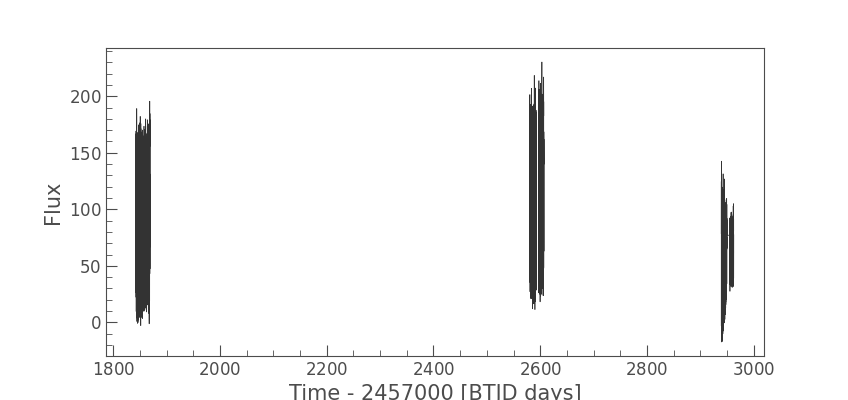

In [7]:
# Gets the lightcurves into a list[Lightcurve]
lcs = get_lightcurves(TIC, author = 'SPOC', cadence='short', use_till=100, use_from=0)
lightcurve = combine_lightcurves(lcs)
lightcurve.plot()

Gaps at times: [1854.8614735]
[ 8790 17627]
Splining values between  1842.508400422521  and  1854.8614734984003
Splining values between  1856.4017710867338  and  1868.8268100148998
Gaps at times: [2592.9625963]
[ 9011 16491]
Splining values between  2580.4360456531867  and  2592.962596295867
Splining values between  2596.545931345783  and  2606.9444400034845
Gaps at times: [2943.70942144 2949.77203978 2956.24711587]
[ 3297  7508  8373 12783]
Splining values between  2939.1190041904338  and  2943.7094214358367
Splining values between  2943.924704951234  and  2949.7720397799276
Splining values between  2955.0471045654267  and  2956.2471158672124
Splining values between  2956.463784304913  and  2962.587398510892
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471343 entries, 0 to 471342
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   time    471343 non-null  float64
 1   flux    471343 non-null  float64
dtypes: float64(2)


<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

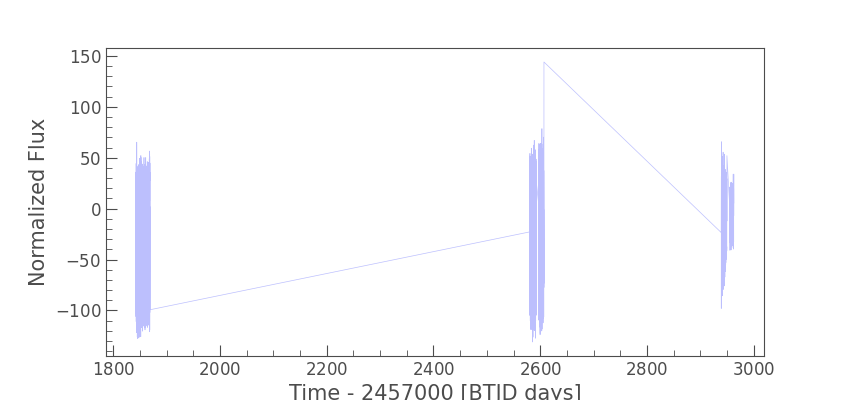

In [8]:
#Preparing the Lightcurves for analysis
new_lcs = []

for lc in lcs:  
    #Removing Nans from the Lightcurves
    df = pd.DataFrame({'time': lc.time.jd, 'flux': np.array(lc.flux, dtype='f')}).dropna(inplace=False)
    new_lc = lk.LightCurve(time= df['time'], flux= df['flux'])

    #new_lc = lc.remove_nans()                  #Potential alternative solution
    
    #Removing the big trends AND increasing the cadence.
    new_lc = apply_savgol_filter(new_lc.time.jd, new_lc.flux, want = 'lc', displaygraphs= False, window_length_for_remove=( 3600*50 )/120, iterations=3)
    new_lc = spline_while_jumping_gaps(new_lc, cadence_magnifier= cadence_magnifier)

    #Storing away the adjusted & splined curve
    new_lcs.append(new_lc)

lightcurve = combine_lightcurves(new_lcs)
lightcurve.plot(color = '#7B81FD', alpha = 0.5, lw = 0.5, ylabel = 'Normalized Flux')

#IMPORTANT Note: The straight lines between gaps seen below are not present in the data, Python adds them just for the graphs to make them visually continuous. The data is not continuous for that part.

FINDING THE PERIOD
-------------

The next section here finds the period to be used for O-C calculations as well as for folding.
A gaussian curve is fit on a Periodogram that is obtained from the desired `lightcurve`.

Please click on the desired peak to make the program process data, the peak should be the tallest peak in the entire mess of principle peak.

PS: Clicking on a point draws a gaussian which is selected for the O-C calculations. If you miss-clicked, just click on the right point afterwards and it will draw a curve in a different color, allowing you to choose another point.

Guessed peak width is 0.00044639708525322377
112007


FigureWidget({
    'data': [{'marker': {'size': 7, 'symbol': 'x'},
              'mode': 'markers',
              'name': 'Peaks',
              'type': 'scatter',
              'uid': 'f5850f85-0bed-4439-af58-1071ea3aedcd',
              'x': {'bdata': ('/D3Me1/v8T/ps9SBrfrxP95geRLwZh' ... 'IUVGEzQBya/lUGYjNA7CfV5rliM0A='),
                    'dtype': 'f8'},
              'y': {'bdata': ('pW7LDKHb/D/xKX0pder8PwVqFB7suf' ... 'wQNcQBQNeoU9Hm7ABAmum0JeUO/z8='),
                    'dtype': 'f8'}},
             {'line': {'color': 'black'},
              'mode': 'lines',
              'name': 'Periodogram',
              'type': 'scatter',
              'uid': 'a5861669-96d3-4a47-b58a-5b480b690bde',
              'x': {'bdata': ('4kistHBnJz/iSKy0cGc3P6o2gYeUjU' ... 'De/zNATFW0xOn/M0Cir2x49f8zQA=='),
                    'dtype': 'f8'},
              'y': {'bdata': ('ckvGNqc9nj8XSOkDWzeeP2bn8CWLHJ' ... 'ZTMso/wZC4JpyExz8SozvNFDPFPw=='),
                    'dtype': 'f8'}}],
    'layout': {'

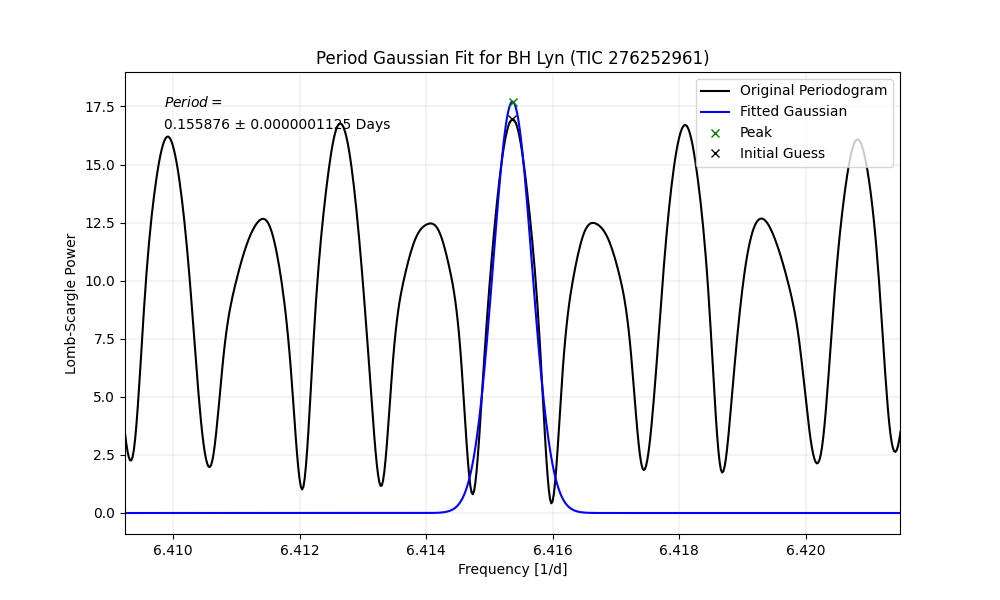

In [9]:
periodogram = lightcurve.to_periodogram(maximum_frequency = 20)

peak_width = 1 / ( (lightcurve.time.btjd[-1] - lightcurve.time.btjd[0]) * 2)
print(f'Guessed peak width is {peak_width}')
max_power = periodogram.max_power.value
optimized_parameters_global = []

frequencies = periodogram.frequency.value
print(len(frequencies))
power = periodogram.power.value
f = np.linspace(frequencies.min(), frequencies.max(), 1000000)
p = spline(frequencies, power, k = 3)(f)

peaks, peakdict = signal.find_peaks(p, height = max_power/10)
peaks_df = pd.DataFrame({'frequencies': f[peaks], 'power': p[peaks], 'peak_index': peaks})
periodogram_df = pd.DataFrame({'frequencies': f, 'power': p})

fi = go.FigureWidget([
    go.Scatter(x=f[peaks], y=p[peaks], mode = 'markers', name = 'Peaks', marker = {
        'symbol': 'x',
        'size': 7,
    }),
    go.Scatter(x=frequencies, y=power, mode='lines', name = 'Periodogram', line = dict(color='black')),
], layout = go.Layout(title = 'Periodogram Peaks', xaxis_title = 'Frequency [1/d]', yaxis_title = 'Power'))

scatter = fi.data[0]
fi.layout.hovermode = 'closest'

global_periods_uncertainities = []
global_periods = []

def update_point(trace, points, selector):
    for i in points.point_inds:
        initial_guess = [peaks_df['power'][i], peaks_df['frequencies'][i], peak_width]
        point_freq = peaks_df['frequencies'][i]

        zoomed_df = periodogram_df[periodogram_df['frequencies'].between(point_freq - (1.5*peak_width), point_freq + (1.5*peak_width))]

        optimized_parameters, covariance = optimize.curve_fit(gaussian, zoomed_df['frequencies'], zoomed_df['power'], p0=initial_guess)
        amp, cen, wid = optimized_parameters

        fitted_gaussian = gaussian(frequencies, amp, cen, wid)
        initial_gaussian = gaussian(frequencies, *initial_guess)
        fitted_gaussian_again = gaussian(f, amp, cen, wid)

        fi.add_trace(go.Scatter(x=frequencies, y=initial_gaussian, mode='lines', name='Initial Gaussian', line=dict(color=next(color_change()))))
        fi.add_trace(go.Scatter(x=frequencies, y=fitted_gaussian, mode='lines', name='Fitted Gaussian', line=dict(color=next(color_change()))))
        optimized_parameters_global.append(optimized_parameters)
        print(optimized_parameters_global[-1])


        fig, ax = plt.subplots(figsize = (10, 6))
        ax.plot(f, p, label = "Original Periodogram", color = 'black')
        # ax.plot(zoomed_df['frequencies'], zoomed_df['power'], label = "Zoomed Periodogram", color = 'red')
        ax.plot(f, fitted_gaussian_again, label = 'Fitted Gaussian', color = 'blue')
        ax.plot(cen, amp, 'x', label = 'Peak', color = 'green')        
        ax.plot(initial_guess[1], initial_guess[0], 'x', label = 'Initial Guess', color = 'black')
        ax.set_xlim(cen - 20*wid, cen + 20*wid)
        ax.set_title(f'Period Gaussian Fit for {current_star}')
        ax.set_xlabel('Frequency [1/d]')
        ax.set_ylabel('Lomb-Scargle Power')


        period_uncertainity = float(np.sqrt(covariance[1, 1]))/(cen**2)
        global_periods_uncertainities.append(period_uncertainity)
        global_periods.append(1/cen)

        period_here = f"{round(1/cen, 6)} ± {period_uncertainity:.10f} Days"

        print(f'Period is {1/cen} ± {period_uncertainity:.10f} Days')
        print("Ucertainity in seconds is ", period_uncertainity*24*60*60)

        plt.text(0.05, 0.95, f'$Period =$', transform=plt.gca().transAxes, fontsize=10, 
         verticalalignment='top', horizontalalignment='left')
        plt.text(0.05, 0.90, f'{round(1/cen, 6)} ± {period_uncertainity:.10f} Days', transform=plt.gca().transAxes, fontsize=10, 
         verticalalignment='top', horizontalalignment='left')
        

        ax.grid(True, linewidth = 0.2)
        ax.legend(loc = 'upper right')
    
scatter.on_click(update_point)
fi


In [10]:
try:
    fitted_frequency = optimized_parameters_global[-1][1]
    fitted_period = 1/fitted_frequency
except:
    raise ValueError('No peaks clicked yet, please click on a peak to fit a gaussian to it.')

print(f'Fitted Frequency: {fitted_frequency}')
print(f'Fitted Period: {fitted_period}')

old_fitted_period = fitted_period.copy()

Fitted Frequency: 6.4153626040386955
Fitted Period: 0.1558758345740995


In [58]:
fitted_period += ((1/86400) * (global_corrections[-1]))
fitted_period

NameError: name 'global_corrections' is not defined

In [ ]:
(old_fitted_period-fitted_period)*86400

DIVIDING INTO CHUNKS
----------

Next part of the code divides the lightcurve into chunks and also removes any chunks that have less that 80% of the average number of values.

In [11]:
#Dividing the lightcurve into chunks, the size of a chunk is the fitted period.
lightcurve_df = pd.DataFrame({'time': lightcurve.time.btjd, 'flux': np.array(lightcurve.flux, dtype='f')})
curr_initial_time = lightcurve_df['time'].iloc[0]
curr_end_time = curr_initial_time + fitted_period

chunks = []
chunk_centres = []

for i in tqdm(range(1, no_test_chunks+1)):
    if curr_end_time > lightcurve_df['time'].iloc[-1]:
        all_chunk_count = i
        break
    else:
        #Only the timestamps between initial_time and end_time are stored inside a chunk.
        chunk = lightcurve_df[(lightcurve_df['time'] >= curr_initial_time) & (lightcurve_df['time'] < curr_end_time)]
        curr_initial_time = curr_end_time
        curr_end_time = curr_initial_time + fitted_period


        #Use only the chunks that are within expected lengths
        expected_length = fitted_period * 86400 / (cadence / cadence_magnifier)
        if (len(chunk) < 1.2 * expected_length) and (len(chunk) > 0.8 * expected_length):
            chunks.append(chunk)
            chunk_centres.append(curr_initial_time - (fitted_period/2))

if not all_chunk_count:
    all_chunk_count = no_test_chunks

chunk_lengths = [len(chunk) for chunk in chunks]
avg_chunk_length = pd.Series(chunk_lengths).mean()

print(f'Number of chunks is {len(chunks)}')
print(f'Mean of chunk lengths is {avg_chunk_length}')


  0%|          | 0/60000 [00:00<?, ?it/s]

 12%|█▏        | 7185/60000 [00:09<01:12, 728.08it/s]

Number of chunks is 416
Mean of chunk lengths is 1120.8942307692307


In [ ]:
'''DONT RUN UNLESS YOU WANT IMAGES. Run to save the chunks as images.'''

for i in tqdm(range(len(chunks))):
    plt.figure(figsize=(10, 6))
    plt.title(f'Chunk {i}')
    plt.plot(chunks[i]['time'], chunks[i]['flux'], lw=0.5)
    plt.axvline(chunk_centres[i], color='red', lw=0.5)
    plt.savefig(f'AnotherChunks/{i}.png')
    plt.close()

INFORMING THE PROGRAM ABOUT THE POSITION OF THE GAUSSIAN
---------
Click on two points that, according to you, give a good '[Full Width at Half Maximum](https://en.wikipedia.org/wiki/Full_width_at_half_maximum).' The program will use this as an initial guess, majorly for horizontal position. Leave the rest to the Gods and destiny.

Also, the default chunk used as sample is the first one. If you want a different `nth` chunk, enter into `chunk_num`.

PS: You can chose more than once, it will just use your final choice.

In [12]:
chunk_num = 43  #Which chunk to use for testing?

sample_chunk = chunks[chunk_num]
chunk_centre = chunk_centres[chunk_num]
sample_chunk_markers = sample_chunk.iloc[::10, :]

gaussian_peak_width = 0
gaussian_position_relative_to_centre = 0

chunk_fi = go.FigureWidget([
    go.Scatter(x=sample_chunk_markers['time'], y=sample_chunk_markers['flux'], mode='markers', name='Sampled Points', marker= {'symbol': 'bowtie', 'size': 10, 'color':'red'}),
    go.Scatter(x=sample_chunk['time'], y=sample_chunk['flux'], mode='lines', name='Chunk', line=dict(color='blue')),
], layout = go.Layout(title=f'Sample Chunk Gaussian Fit for {current_star}', xaxis_title='Time [BTJD]', yaxis_title='Normalized Flux', autosize=False, width = 1500, height=700))

chunk_scatter = chunk_fi.data[0]
chunk_fi.layout.hovermode = 'closest'


def first_input(trace, points, selector):
    '''
    This function is used to store the first point clicked in the chunk.
    '''
    global point1_time
    global point1_flux
    point1_time = points.xs[0]
    point1_flux = points.ys[0]

def second_input(trace, points, selector):
    '''
    Takes in the second point clicked and fits a gaussian to the chunk. The main function is to get the peak width and position relative to the centre.
    '''
    global point2_time
    global point2_flux
    global gaussian_peak_width
    global gaussian_position_relative_to_centre
    point2_time = points.xs[0]
    point2_flux = points.ys[0]

    gaussian_peak_width = abs(point2_time - point1_time)
    gaussian_position_relative_to_centre = (point2_time + point1_time)/2 - chunk_centre

    height = 0 - sample_chunk['flux'].min()
    cen = chunk_centre + gaussian_position_relative_to_centre
    width = gaussian_peak_width

    initial_guess = [height, cen, width]
    optimized_parameters, covariance = optimize.curve_fit(inverse_gaussian, sample_chunk['time'], sample_chunk['flux'], p0=initial_guess)
    amp, cen, wid = optimized_parameters

    fitted_gaussian = inverse_gaussian(sample_chunk['time'], amp, cen, wid)
    initial_gaussian = inverse_gaussian(sample_chunk['time'], *initial_guess)

    chunk_fi.add_trace(go.Scatter(x=sample_chunk['time'], y=fitted_gaussian, mode='lines', name='Fitted Gaussian', line=dict(color=next(color_change()))))
    chunk_fi.add_trace(go.Scatter(x=sample_chunk['time'], y=initial_gaussian, mode='lines', name='Initial Gaussian', line=dict(color=next(color_change()))))
    chunk_fi.add_trace(go.Scatter(x=[cen, cen], y=[sample_chunk['flux'].min(), sample_chunk['flux'].max()], mode='lines', name='Fitted Eclipse Centre', line=dict(color='red', dash='dash')))

current_func = first_input

def toggle_clicker(trace, points, state):
    global current_func
    current_func(trace, points, state)

    # Switch to the other function
    if current_func == first_input:
        current_func = second_input
    else:
        current_func = first_input

chunk_scatter.on_click(toggle_clicker)
chunk_fi



FigureWidget({
    'data': [{'marker': {'color': 'red', 'size': 10, 'symbol': 'bowtie'},
              'mode': 'markers',
              'name': 'Sampled Points',
              'type': 'scatter',
              'uid': 'd68adbcd-8818-4c60-8ca7-9f3afcf6ddd7',
              'x': {'bdata': ('AMjvMNjknEAAuAed2eScQACoHwnb5J' ... 'N05ZxAAKBQD3blnEAAkGh7d+WcQA=='),
                    'dtype': 'f8'},
              'y': {'bdata': ('trSUQe7BmUF783VB0VotQX3p2z/vdI' ... '1A/DkNQYvgikHXoJlB3FbbQZ0RsUE='),
                    'dtype': 'f4'}},
             {'line': {'color': 'blue'},
              'mode': 'lines',
              'name': 'Chunk',
              'type': 'scatter',
              'uid': 'e37082e4-4311-4c40-b61a-2b6cb786d6e1',
              'x': {'bdata': ('AMjvMNjknEAAkFhV2OScQABgwXnY5J' ... 'j/VnflnEAAkGh7d+WcQABg0Z935ZxA'),
                    'dtype': 'f8'},
              'y': {'bdata': ('trSUQZeQmkF/NZ9Bdk2iQSr2o0EuXa' ... 'HNQaI9xkGfub5BkYG3QZ0RsUHp5atB'),
                    'dtype': '

In [ ]:
'''NO NEED UNLESS FOR TESTING: Creates a dataframe and a csv file with the chunk data.'''

chunks_df = pd.DataFrame({
    'chunk' : chunks,
    'chunk_number' : [i for i in range(len(chunks))],
    'chunk_len' : [len(chunk) for chunk in chunks],
}).to_csv('chunks.csv', index=False)

chunks[0]

FITTING GAUSSIANS INTO CHUNKS
--------

We will take a random guess and try fitting with that guess.

In [14]:
#List to store all the times of the peak of the gaussian.
observed_centers = []

for i in tqdm(range(len(chunks))):
    height = 0 - chunks[i]['flux'].min()
    cen = chunk_centres[i] + gaussian_position_relative_to_centre
    width = gaussian_peak_width

    initial_guess = [height, cen, width]
    try:
        optimized_parameters, covariance = optimize.curve_fit(inverse_gaussian, chunks[i]['time'], chunks[i]['flux'], p0=initial_guess)
        amp, cen, wid = optimized_parameters

        fitted_gaussian = inverse_gaussian(chunks[i]['time'], amp, cen, wid)
        initial_gaussian = inverse_gaussian(chunks[i]['time'], *initial_guess)

        observed_centers.append(cen)
    except:
        print(f"problem at chunk {i}.")
        print(f"Initial guess was {initial_guess[1]}")
        observed_centers.append(initial_guess[1])
        continue

    

100%|██████████| 416/416 [00:06<00:00, 64.20it/s]


In [ ]:
'''Maybe another way of fitting the gaussians?'''
observed_centers = []

for i in tqdm(range(len(chunks))):
# for i in tqdm(range(100)):
    height = 0 - chunks[i]['flux'].min()
    cen = chunk_centres[i] + gaussian_position_relative_to_centre
    width = gaussian_peak_width

    relevant_chunk = chunks[i][ chunks[i]['time'].between(cen - (2.5*width), cen + (3*width)) ]

    initial_guess = [height, cen, width]
    try:
        optimized_parameters, covariance = optimize.curve_fit(inverse_gaussian, relevant_chunk['time'], relevant_chunk['flux'], p0=initial_guess)
        amp, cen, wid = optimized_parameters

        fitted_gaussian = inverse_gaussian(chunks[i]['time'], amp, cen, wid)
        initial_gaussian = inverse_gaussian(chunks[i]['time'], *initial_guess)

        # plt.figure(figsize=(10, 5))
        # plt.title(f'Chunk {i} with Gaussian (Focused)')
        # plt.grid(False)
        # plt.plot(chunks[i]['time'], chunks[i]['flux'])
        # plt.plot(relevant_chunk['time'], relevant_chunk['flux'], color='green')
        # plt.plot(chunks[i]['time'], fitted_gaussian, color='red')
        # plt.plot(chunks[i]['time'], initial_gaussian, color = 'black', linestyle='--', alpha=0.5)
        # plt.legend(['Chunk', 'Fitted Gaussian', 'Initial Gaussian'])
        # plt.savefig(f"ChunksWithGaussians3034524/{i} 'focused'.png")
        # plt.close()

        observed_centers.append(cen)
    except:
        print(f"problem at chunk {i}.")
        print(f"Initial guess was {initial_guess[1]}")
        observed_centers.append(initial_guess[1])
        continue

The O-C, FINALLY!
------------

Just let it run, don't sweat.

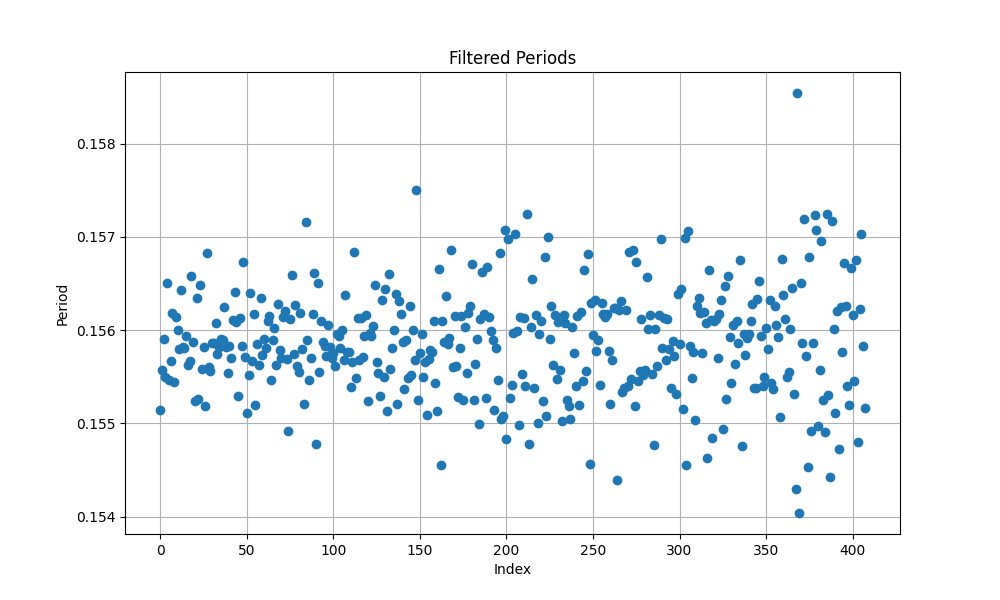

(np.float64(0.15586813482179743), np.float64(0.0005769151301669136))

In [15]:
#Mean period and stuff, not required
periods_here = np.diff(observed_centers)

# Remove outliers from periods_here
mean_period = np.mean(periods_here)
std_period = np.std(periods_here)
filtered_periods = periods_here[(periods_here > mean_period - 2 * std_period) & (periods_here < mean_period + 2 * std_period)]

mean_period = np.mean(filtered_periods)
std_period = np.std(filtered_periods)
filtered_periods = filtered_periods[(filtered_periods > mean_period - 2 * std_period) & (filtered_periods < mean_period + 2 * std_period)]

mean_period = np.mean(filtered_periods)
std_period = np.std(filtered_periods)
filtered_periods = filtered_periods[(filtered_periods > mean_period - 2 * std_period) & (filtered_periods < mean_period + 2 * std_period)]

# Plot the filtered periods
plt.figure(figsize=(10, 6))
plt.plot(filtered_periods, marker='o', linestyle='none')
plt.title('Filtered Periods')
plt.xlabel('Index')
plt.ylabel('Period')
plt.grid(True)
plt.show()

mean_period = np.mean(filtered_periods)
std_period = np.std(filtered_periods)

mean_period, std_period

In [21]:
lightcurve_test = lightcurve_df[: int(avg_chunk_length * no_test_chunks)]

O_C_df = pd.DataFrame(
    {
    'E' : [x for x in range(int(-1.5 * all_chunk_count ), int(1.5 * all_chunk_count))]
    }
)

#Finding the T_0 for Event number 0
centre = (lightcurve_test['time'].min() + lightcurve_test['time'].max())/2
T_0_index = np.searchsorted(observed_centers, centre, side = 'right') + 1
print(f'T_0 index is {T_0_index}')

O_C_df['C'] = observed_centers[T_0_index] + O_C_df['E'] * fitted_period

# Insert observed_centers[i] at E = int((observed_centers[i] - observed_centers[T_0_index])/fitted_period), fill the rest with NaN
O_C_df['O'] = np.nan
for i in range(len(observed_centers)):
    E_value = int(round((observed_centers[i] - observed_centers[T_0_index]) / fitted_period))
    if E_value in O_C_df['E'].values:
        O_C_df.loc[O_C_df['E'] == E_value, 'O'] = observed_centers[i]

O_C_df['O-C'] = (O_C_df['O'] - O_C_df['C'])
# O_C_df = O_C_df.dropna(inplace=False)

def parabola(x, a, b, c):
    return a*(x**2) + b*x + c

def parabola2(x, a, b, c):
    return a*((x-b)**2) + c

another_O_C = O_C_df.dropna(inplace=False)
print("Number of points in O-C:", len(another_O_C))
mean_O_C = O_C_df['O-C'].mean()

T_0 index is 224
Number of points in O-C: 470


In [22]:
#Removing the outliers

stq_up_to_remove = 2
stq_down_to_remove= 2

s = O_C_df['O-C'].std()
print("Points removed = ", len(O_C_df[O_C_df['O-C'].apply(lambda x: True if (x-mean_O_C) > stq_up_to_remove*s else (True if (x-mean_O_C) < -stq_down_to_remove*s else False))]['O-C']))
O_C_df = O_C_df[O_C_df['O-C'].apply(lambda x: False if (x-mean_O_C) > stq_up_to_remove*s else (False if (x-mean_O_C) < -stq_down_to_remove*s else True))]

print("Points removed = ", len(another_O_C[another_O_C['O-C'].apply(lambda x: True if (x-mean_O_C) > stq_up_to_remove*s else (True if (x-mean_O_C) < -stq_down_to_remove*s else False))]['O-C']))
another_O_C = another_O_C[another_O_C['O-C'].apply(lambda x: False if (x-mean_O_C) > stq_up_to_remove*s else (False if (x-mean_O_C) < -stq_down_to_remove*s else True))]


Points removed =  31
Points removed =  31


In [24]:
#Do not run this cell unless you want to fit a parabola to the O-C values.
O_C_fi = go.FigureWidget([
    go.Scatter(x=O_C_df['E'], y=O_C_df['O-C'], mode='markers', name='O-C values', marker= {'symbol': 'x', 'size': 2, 'color':'red'}),
    # go.Scatter(x=O_C_df['E'], y=O_C_df['O-C'], mode='lines', name='O-C again', line=dict(color='blue'), opacity=0.2)
], layout = go.Layout(title=f'O-C for {TIC}', xaxis_title='Event Number', yaxis_title='O-C (d)', autosize=False, width = 1500, height=700))

optimized_parameters_O_C_global = []

O_C_scatter = O_C_fi.data[0]
O_C_fi.layout.hovermode = 'closest'
global_corrections = []

def O_C_curfit_drawer(trace, points, state):
    # c = points.ys[0]
    # E_val = points.xs[0]
    # a = abs(c) / (E_val**2)
    # b = (another_O_C['O-C'].iloc[-1] - another_O_C['O-C'].iloc[0]) / (another_O_C['E'].iloc[-1] - another_O_C['E'].iloc[0])

    a = 0
    b = 0
    c = mean_O_C

    initial_guess = [a, b, c]
    optimized_parameters, covariance = optimize.curve_fit(parabola, another_O_C['E'], another_O_C['O-C'], p0=initial_guess)

    print("The optimized parameters are ", optimized_parameters)
    

    fitted_parabola = parabola(O_C_df['E'], *optimized_parameters)
    initial_parabola = parabola(O_C_df['E'], *initial_guess)


    #Finding the R^2 value
    residuals = O_C_df['O-C'] - fitted_parabola
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((O_C_df['O-C'] - O_C_df['O-C'].mean())**2)
    r_squared = 1 - (ss_res / ss_tot)

    O_C_fi.add_trace(go.Scatter(x=O_C_df['E'], y=initial_parabola, mode='lines', name='Initial Parabola', line=dict(color='blue', dash = 'dash')))
    O_C_fi.add_trace(go.Scatter(x=O_C_df['E'], y=fitted_parabola, mode='lines', name='Fitted Parabola', line=dict(color='black')))

    optimized_parameters_O_C_global.append(optimized_parameters)

    a = optimized_parameters[0]
    b = optimized_parameters[1]
    print(f'fitted_period is {old_fitted_period}')

    p_dot = (2 * a * 1/(old_fitted_period))
    print(f'P_dot is {p_dot}')

    print(f"correction is {b*86400} seconds")

    global_corrections.append(b*86400)


    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(O_C_df['E'], O_C_df['O-C'], lw=0, marker='o', markersize=0.5, label = "O-C", color='black')
    ax.plot(O_C_df['E'], fitted_parabola, lw=1, label = 'Fitted Parabola', color='orange')
    # ax.plot(O_C_df['E'], initial_parabola, lw=1, label = 'Initial Parabola', linestyle='--', alpha=0.5, color = 'green')
    ax.legend(loc=1)
    ax.set_title(f'O-C for {current_star}')
    ax.set_xlabel('E')
    ax.set_ylabel('O-C [days]')

    O_C_std = O_C_df['O-C'].std()

    p_dot_err = abs(p_dot * ((  (float(np.sqrt(covariance[0, 0]))/a)**2 + (global_periods_uncertainities[-1]/global_periods[-1])**2  )**(1/2)))

    print("error in a = ", float(np.sqrt(covariance[0, 0])))
    print("a = ", a)
    

    # Combine the values and adjust the format
    base = p_dot / 10**int(f"{p_dot:.3e}".split("e")[-1])  # Extract base
    err_base = p_dot_err / 10**int(f"{p_dot:.3e}".split("e")[-1])  # Adjust error to same base
    exponent = int(f"{p_dot:.3e}".split("e")[-1])  # Get exponent

    # Format the result as required
    formatted_result = f"({base:.3f}  ±  {err_base:.3f})e{exponent}"


    plt.text(0.05, 0.95, r'$\sigma$' + f" $(O-C) = {O_C_std:.5f}$", transform=plt.gca().transAxes, fontsize=10)
    plt.text(0.05, 0.90, f'$R^2 (O-C)= {r_squared:.5f}$', transform=plt.gca().transAxes, fontsize=10)

    plt.text(0.05, 0.85, f'$\dot P = {formatted_result}$ days/day', transform=plt.gca().transAxes, fontsize=10)

    ax.grid(True, linewidth = 0.2)
    
O_C_scatter.on_click(O_C_curfit_drawer)
O_C_fi


FigureWidget({
    'data': [{'marker': {'color': 'red', 'size': 2, 'symbol': 'x'},
              'mode': 'markers',
              'name': 'O-C values',
              'type': 'scatter',
              'uid': 'cb6de744-945d-4032-9b34-50d75c6a4814',
              'x': {'bdata': ('frp/uoC6gbqCuoO6hLqFuoa6h7qIuo' ... 'dFeEV5RXpFe0V8RX1FfkV/RYBFgUU='),
                    'dtype': 'i2'},
              'y': {'bdata': ('AAAAAAAA+H8AAAAAAAD4fwAAAAAAAP' ... 'AAAAD4fwAAAAAAAPh/AAAAAAAA+H8='),
                    'dtype': 'f8'}}],
    'layout': {'autosize': False,
               'height': 700,
               'hovermode': 'closest',
               'template': '...',
               'title': {'text': 'O-C for TIC 364173220'},
               'width': 1500,
               'xaxis': {'title': {'text': 'Event Number'}},
               'yaxis': {'title': {'text': 'O-C (d)'}}}
})

[ 9.69954932e-20 -3.98576816e-05 -1.64813017e-13]
fitted_period is 0.08695703459793915
P_dot is 3.1566504899692256e-10


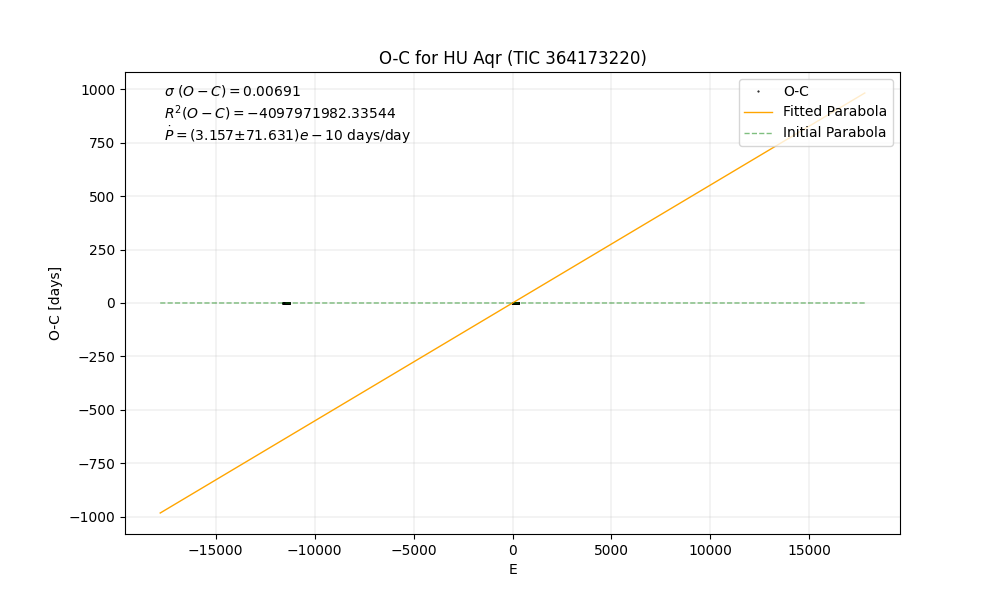

In [23]:
optimized_parameters_O_C_global = []

a = 0
b = 0
c = mean_O_C

initial_guess = [a, b, c]
optimized_parameters, covariance = optimize.curve_fit(parabola2, another_O_C['E'], another_O_C['O-C'], p0=initial_guess)

print(covariance[0])


fitted_parabola = parabola(O_C_df['E'], *optimized_parameters)
initial_parabola = parabola(O_C_df['E'], *initial_guess)


#Finding the R^2 value
residuals = O_C_df['O-C'] - fitted_parabola
ss_res = np.sum(residuals**2)
ss_tot = np.sum((O_C_df['O-C'] - O_C_df['O-C'].mean())**2)
r_squared = 1 - (ss_res / ss_tot)

optimized_parameters_O_C_global.append(optimized_parameters)

a = optimized_parameters[0]
print(f'fitted_period is {old_fitted_period}')
p_dot = (2 * a * 1/(old_fitted_period))
print(f'P_dot is {p_dot}')


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(O_C_df['E'], O_C_df['O-C'], lw=0, marker='o', markersize=0.5, label = "O-C", color='black')
ax.plot(O_C_df['E'], fitted_parabola, lw=1, label = 'Fitted Parabola', color='orange')
ax.plot(O_C_df['E'], initial_parabola, lw=1, label = 'Initial Parabola', linestyle='--', alpha=0.5, color = 'green')
ax.legend(loc=1)
ax.set_title(f'O-C for {current_star}')
ax.set_xlabel('E')
ax.set_ylabel('O-C [days]')

O_C_std = O_C_df['O-C'].std()

p_dot_err = abs(p_dot * ((  (float(np.sqrt(covariance[0, 0]))/a)**2 + (global_periods_uncertainities[-1]/global_periods[-1])**2  )**(1/2)))

# Combine the values and adjust the format
base = p_dot / 10**int(f"{p_dot:.3e}".split("e")[-1])  # Extract base
err_base = p_dot_err / 10**int(f"{p_dot:.3e}".split("e")[-1])  # Adjust error to same base
exponent = int(f"{p_dot:.3e}".split("e")[-1])  # Get exponent

# Format the result as required
formatted_result = f"({base:.3f}  ±  {err_base:.3f})e{exponent}"


plt.text(0.05, 0.95, r'$\sigma$' + f" $(O-C) = {O_C_std:.5f}$", transform=plt.gca().transAxes, fontsize=10)
plt.text(0.05, 0.90, f'$R^2 (O-C)= {r_squared:.5f}$', transform=plt.gca().transAxes, fontsize=10)

plt.text(0.05, 0.85, f'$\dot P = {formatted_result}$ days/day', transform=plt.gca().transAxes, fontsize=10)


ax.grid(True, linewidth = 0.2)



In [ ]:
(4.982 * 10**-11) * 86400 * 365.25

In [ ]:
import pandas as pd

In [ ]:
df1 = pd.DataFrame({"A": [1, 2], "B":[3, 4]})
df2 = pd.DataFrame({"B": [5, 6], "D":[7, 8]})
df1 + df2